# CM50268 :: Final project

**Total Marks 25 (25% of overall unit grade).** 

*Submission deadline: 8pm, May 10, 2022. Please submit this file along with your individual report in Moodle*

## Submission & Marking

This exercise is assessed, and the marks will contribute to your final grade. For this exercise there are a number of places where you are expected to enter your own code. Please see the BML Final Project Specification document for details. 

Every place you have to add code is described in the text and specifically indicated by the comment:

`#### **** YOUR CODE HERE **** ####`


**Please submit your completed workbook using Moodle before 8pm on May 10, 2022 along with your individual report**. The workbook you submit must be this `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

# Project setup

This coursework involves the evaluation of Bayesian modelling methods on a real multivariate regression task. Please check the pdf file for the details of the project.

- <font color=Red> Please try to use fixed random seeds to make your results reproducible </font>

- <font color=Red> Please do NOT change the name of the fixed variables, as Task 2 - Task 5 of this coding exercises are auto-marked </font>

The marks for Task 1 will be awarded based only on the content of the report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.special import gamma
from scipy import stats

import hmc_Lab as hmc

# Task 1 : Exploratory analysis (Section 4.1 in the specification doc)

Undertake an initial exploratory analysis of the training data and summarise. Code in Task 1 will NOT by auto-marked. Results of Task 1 will be assessed along with your individual report, i.e., 4 marks in total. 

 - <font color=Red> Please perserve the variables `X_train` and  `y_train` representing the normalised data in numpy array, as required for the following exercises  </font>

 - `X_train` is an np.array with shape (384, 9). The 1st column is a constant (bias) $x_0$ and the 2nd to the 9th columns are data variables $x_1,x_2,\dots,x_8$

 - `y_train` is also an np.array with shape (384,), representing the target variable $y$ 

In [2]:
#### **** YOUR CODE HERE **** ####  
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

col = train.columns[1:]
y_train = train.iloc[:,-1].values
y_test = test.iloc[:,-1].values

scaler = StandardScaler()
train_s = scaler.fit_transform(train.iloc[:,1:])
test_s = scaler.transform(test.iloc[:,1:])

train = pd.concat([pd.DataFrame(train.iloc[:,0]), pd.DataFrame(train_s, columns=col)], axis=1)
test = pd.concat([pd.DataFrame(test.iloc[:,0]), pd.DataFrame(test_s, columns=col)], axis=1)

X_train = train.iloc[:,:-1].values
X_test = test.iloc[:,:-1].values

#### **** You can add extra cells to illustrate your results **** ####  

In [3]:
# Check whether fixed variables are correctly defined ..
try:
    if not isinstance(X_train,np.ndarray):
        print('X_train should be an array')        
    if X_train.shape != (384,9):
        print('X_train is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(y_train,np.ndarray):
        print('y_train should be an array')        
    if y_train.shape != (384,):
        print('y_train is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)

In [4]:
print('Training set missing value check: ',train.isnull().any().any())
print('Testing set missing value check:  ',test.isnull().any().any())

Training set missing value check:  False
Testing set missing value check:   False


<AxesSubplot:>

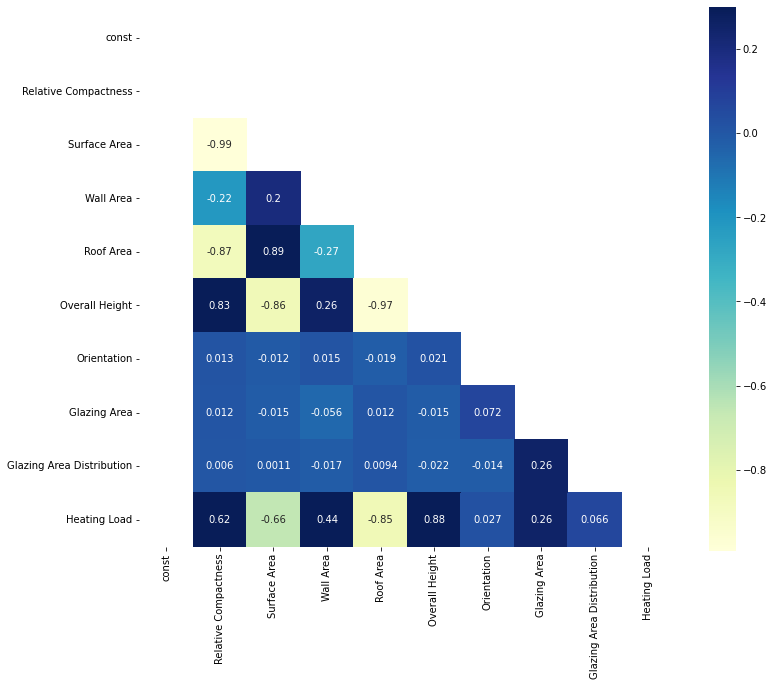

In [5]:
plt.figure(figsize=(12,10))
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu", annot=True)

In [6]:
import statsmodels.api as sm
est = sm.OLS(y_train, X_train).fit()
y_pred_train = est.predict(X_train)
y_pred_test = est.predict(X_test)

def rmse(pred, y):
    err = np.sqrt(np.mean((y - pred) ** 2))
    return err

err_train = rmse(y_train, y_pred_train)
err_test = rmse(y_test, y_pred_test)

print('RMSE Train set:', err_train)
print('RMSE Test set', err_test)

RMSE Train set: 3.0115517876503617
RMSE Test set 2.8435880167333694


#  Task 2 : Type-2 maximum likelihood (Section 4.2 (a) in the specification doc)

###  **(6 marks)**

Precisions are defined as: $\alpha = 1 / \sigma_w^2$ and $ \beta = 1 / \sigma_{\epsilon}^2 $

Assume priors of $\alpha$ and $\beta$ follow flat Uniform distributions, please derive a likelihood function $(y|\alpha, \beta)$ (`compute_log_marginal`) to compute the *log-ikelihood* for the Bayesian linear regression problem using $X$ and hyperparameters $\alpha$ and $\beta$. 

In Lecture 4, slide 11 and 12 we have illustrated the equations of finding the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters (slide 12).


`X`: this is an np.array equivalent to matrix $X$ in the specification doc, e.g., `X_train`, `X_test`.

`y`: this is an np.array equivalent totarget $y$ in the specification doc, e.g., `y_train`, `y_test`.


In [7]:
## Compute log-likelihood



def compute_log_marginal(X, y, alph, beta):
    #### **** YOUR CODE HERE **** ####   
    X_trans = X.T
    y_trans = y.T
    id_m = np.identity(X.shape[0])
    
    cov = (1/beta * id_m) + (X @ X_trans / alph)
    lgp = stats.multivariate_normal.logpdf(y_trans, cov=cov, allow_singular=True)
    
    return lgp

Compute log-evidence (marginal likelihood) `log_prob_y` and plot the 'contourf' of the log-posterior distribution.

- The x-axis should be the value of $log \alpha$ and y-axis the $log\beta$, `log_prob_y` represents the log-evidence. For each axis, it is recommended to use 
`np.linspace(-5,0,100)`

- It is strongly recommended that you use only natural logarithms for hyper-parameter scales. That is, you would use `numpy.exp()` and `numpy.log()` functions to convert (or to convert back) the logarithm terms.

In [8]:
#### **** YOUR CODE HERE **** ####   

alpha_space = np.linspace(-5, 0, 100)
beta_space = np.linspace(-5, 0, 100)

plateau = -99999999999999999999999999999
best_alpha = 0
best_beta = 0
log_prob_y = []

for b in beta_space:
    log = []
    for a in alpha_space:
        alph = np.exp(a)
        beta = np.exp(b)
        lgp = compute_log_marginal(X_train, y_train, alph, beta)
        log.append(lgp)
        if lgp > plateau:
            plateau = lgp
            best_alpha = alph
            best_beta = beta
    log_prob_y.append(log)

    
log_prob_y = np.array(log_prob_y)

# best_alpha = np.exp(best_alpha)
# best_beta = np.exp(best_beta)
# Check whether your variables are correctly defined ..
try:
    if not isinstance(log_prob_y,np.ndarray):
        print('log_prob_y should be an array')
    if log_prob_y.shape != (100,100):
        print('log_prob_y is arranged in a wrong shape')
except Exception as err:
    print('Error output:', err)

Print out the most proboble values of the parameters $\alpha$ and $\beta$ and the corresponding log-likelihood value.

In [9]:
#### **** YOUR CODE HERE **** ####
print('Best alpha:', best_alpha)
print('Best beta:', best_beta)

Best alpha: 0.01174362845702136
Best beta: 0.10836802322189586


Visualisation using `plt.contourf`for the posterior distribution and indicate the most probable value (with a highlighted marker) in the graph.

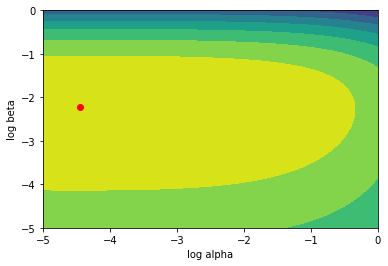

In [10]:
#### **** YOUR CODE HERE **** ####   
# plt.title()
plt.contourf(alpha_space, beta_space, log_prob_y)
plt.scatter(np.log(best_alpha), np.log(best_beta), c="red")

plt.xlabel("log alpha")
plt.ylabel("log beta")
plt.show()

Write a function `compute_posterior(X, y, alph, beta)`  to compute the posterior mean $\mathbf{\mu}$ (`Mu`) and covariance $\mathbf{\Sigma}$ (`SIGMA`) for the Bayesian linear regression model, and return `Mu` and `SIGMA` for the posterior in the np.array format. 

In [11]:
def compute_posterior(X, y, alph, beta):
    #### **** YOUR CODE HERE **** ####
    M = X.shape[1]
    H = beta*(X.T @ X) + alph*np.eye(M)
    SIGMA = np.linalg.inv(H)
    Mu = beta * (SIGMA @ (X.T @ y))
    
    return Mu, SIGMA

Calculate the predicted weights and print out the corresponding RMSE for training and test sets.

In [12]:
#### **** YOUR CODE HERE **** ####

def fit_pls(X, y, alph, beta):
    lam = alph * (1/beta)
    I = np.identity(len(np.dot(X.T, X)))
    w = np.dot(np.linalg.inv(np.dot(X.T, X) + lam * I), np.dot(X.T , y))

    return w

def predict_weights(X_test, X_train, y_train, alph, beta):
    prediction = np.dot(X_test, fit_pls(X_train, y_train, alph, beta))
    return prediction


err_train = rmse(y_train, np.dot(X_train, fit_pls(X_train, y_train, alph, beta)))
err_test = rmse(y_test, np.dot(X_test, fit_pls(X_train, y_train, alph, beta)))

print('RMSE Train set:', err_train)
print('RMSE Test set', err_test)

RMSE Train set: 3.017731120905287
RMSE Test set 2.848464777499566


# Task 3: Variational Inference (Section 4.2 (b) in the specification doc)

###  **(4 marks)**

Write a Variational Inference function `VI(X_train, Y_train)` and return parameter estimates. 

The returned terms should include:

`an`, `bn`, `cn`, `dn`: float

`mn_n`: np.array, shape = (9,),

`sig_n`: np.array, shape = (9,9),

where

`an` and `bn` are the hyper-parameters for $w\propto  N(w|0,\alpha)$,  $\alpha\propto Gamma(\alpha|a,b) $. 

`cn` and `dn` are the hyper-parameters for gaussian noise $N(0,\beta)$,  $\beta\propto Gamma(\beta|c,d) $.

`mn_n` and `sig_n` are the mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ of the posterior distribution w.r.t. $w$ (in this task) for the Bayesian linear regression model.

The corresponding derivations should be completed in your report.



In [13]:
from scipy.special import gamma

def VI(X_train, Y_train):
    #### **** YOUR CODE HERE **** ####
    a0 = b0 = c0 = d0 = 10 ** (-4)
    x_trans = X_train.T @ X_train
    alph = a0 / b0
    beta = c0 / d0
    N, M = X_train.shape
    an = a0 + (1/2) * M
    cn = c0 + (1/2) * N
    for i in range(100):
        sig_n = np.linalg.inv(beta * x_trans + alph * np.eye((x_trans.shape[0])))
        mu_n = beta * np.dot(np.dot(sig_n, X_train.T), Y_train)
        bn = b0 + (1/2) * (mu_n.T @ mu_n + np.trace(sig_n))        
        alph = an / bn        
        dn = d0 + (1/2) * (pow(np.linalg.norm(Y_train - (X_train @ mu_n)),2) + np.trace(x_trans @ sig_n))
        beta = cn / dn
        
    return an, bn, cn, dn, mu_n, sig_n

Y_train = y_train

Print out the expectation of $\alpha$ and $\beta$ as `exp_alpha`,`exp_beta`. 


In [14]:
try:
    an,bn,cn,dn, mu_n, sig_n = VI(X_train, Y_train)
except Exception as err:
    print('Error output:', err)
    
#### Print out the expectation of alpha and beta
#### **** YOUR CODE HERE **** ####

exp_alpha = an / bn
exp_beta = cn / dn
print('exp_alpha:',exp_alpha)
print('exp_beta:',exp_beta)

exp_alpha: 0.011924492482214537
exp_beta: 0.10797302453887349


In [15]:
# Check whether your variables are correctly defined  ..
try:
    if not isinstance(mu_n,np.ndarray):
        print('mu_n should be an array')        
    if mu_n.shape != (9,):
        print('mu_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(sig_n,np.ndarray):
        print('sig_n should be an array')        
    if sig_n.shape != (9,9):
        print('sig_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    exp_alpha
    exp_beta
except Exception as err:
    print('Error output:', err)

Calculate the RMSE for training and test sets.

In [16]:
#### **** YOUR CODE HERE **** ####
err_train = rmse(y_train, np.dot(X_train, fit_pls(X_train, Y_train, exp_alpha, exp_beta)))
err_test = rmse(y_test, np.dot(X_test, fit_pls(X_train, Y_train, exp_alpha, exp_beta)))

print('RMSE Train set:', err_train)
print('RMSE Test set', err_test)

RMSE Train set: 3.011699793170418
RMSE Test set 2.8434357594736372


# Task 4: Verify HMC on a standard 2D Gaussian example (Section 4.3 in the specification doc)

###  **(4 marks)**

## The "Distribution"

Complete the following functions:

- `energy_func(x)`: the energy function, return negative log pdf value in float format
- `energy_grad(x)`: the gradient function returns a numpy array containing the partial derivatives of the energy function with respect to the parameters/hyper-parameters.
- `covar`: Covariance matrix for 2-dimensional gaussian. It is an numpy array with shape (2,2), e.g,  np.array([[1.0875,1],[1,1.0875]]) 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`



In [17]:
#553
def energy_func(x, covar):
    #### **** YOUR CODE HERE **** ####
    neglgp = -stats.multivariate_normal.logpdf(x, mean=[0,0], cov=covar)
    return neglgp

#27 #78
def energy_grad(x, covar):
    #### **** YOUR CODE HERE **** ####
    g = np.linalg.inv(covar)@(x-[0,0])
    return g


## Visualising the Distribution
Before we run the sampler, let's visualise the distribution over an appropriate
grid of values. Please specify `covar` to plot figures, an naive example of `covar` has been shown below

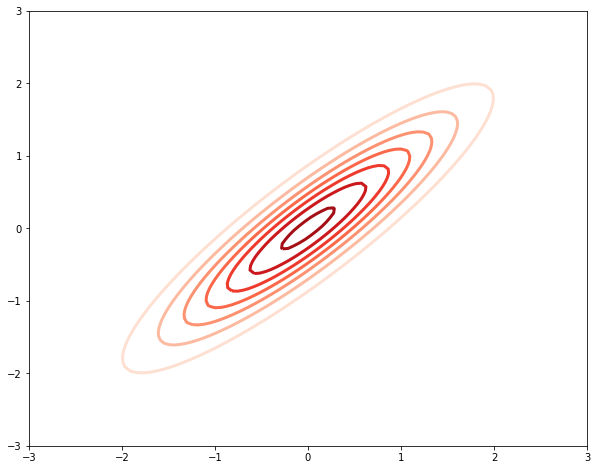

In [18]:

#### **** YOUR CODE BELOW **** ####

covar = np.array([[1,0.9],[0.9,1]]) 

#### **** YOUR CODE ABOVE **** ####

f = 5  # The "frequency" argument for the energy, used here to demonstrate how to use "args"
# Other plotting parameters
fsz = (10,8)
gsz = 100
lim = 3

# Setup the mesh grid

gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))

# Plot the figure
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, covar)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [19]:
try:
    if not isinstance(covar ,np.ndarray):
        print('covar  should be an array')        
    if covar .shape != (2,2):
        print('covar  is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)

In [20]:
# Initialise the state for the first time step
x0 = np.random.normal(size=2)

# Call the function from the pre-defined hmc module
hmc.gradient_check(x0, energy_func, energy_grad, covar)

Calc.         Numeric       Delta         Acc.
    -11.6887      -11.6887   7.826237e-10  11
     9.99173       9.99173  -4.448779e-10  11


## Hyper-parameters

Please tune optimal hyper-parameters incluidng `R`, `L`, and `eps` in the cell below. 

Calc.         Numeric       Delta         Acc.
    -11.6887      -11.6887   7.826237e-10  11
     9.99173       9.99173  -4.448779e-10  11
|----------|  0% accepted [ 27 secs to go ]
|#---------| 90% accepted [ 30 secs to go ]
|##--------| 90% accepted [ 31 secs to go ]
|###-------| 90% accepted [ 26 secs to go ]
|####------| 90% accepted [ 22 secs to go ]
|#####-----| 90% accepted [ 17 secs to go ]
|######----| 90% accepted [ 13 secs to go ]
|#######---| 90% accepted [ 10 secs to go ]
|########--| 90% accepted [ 6 secs to go ]
|#########-| 90% accepted [ 3 secs to go ]
|##########| 90% accepted [ 0 secs to go ]
HMC: R=10000 / L=100 / eps=0.39 / Accept=90.4%


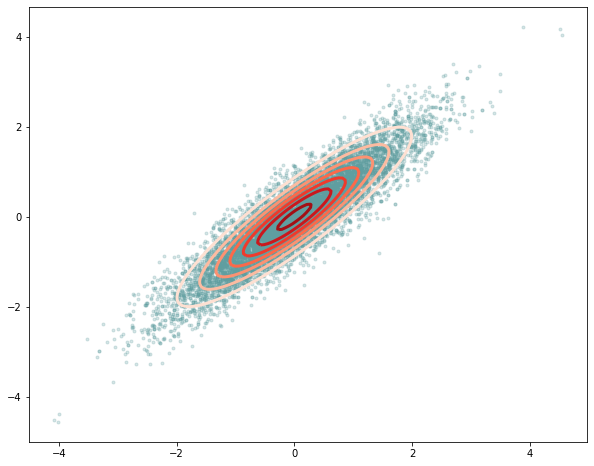

In [21]:
np.random.seed(seed=1)  # Fix the random seed for better reproducibility

#### **** YOUR CODE BELOW **** ####


R= 10000
L = 100
eps = 0.39
burn = int(R/10) 

#### **** YOUR CODE ABOVE **** ####

# HMC sampling
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=True, args=[covar])
# Plot the figure
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [22]:
#### **** YOUR CODE HERE **** ####

#### **** You can add extra figures to support the individual report **** ####

# Task 5: Apply HMC to the Linear Regression Model (Section 4.4 in the specification doc)

###  **(8 marks)**

Complete the functions and the HMC code for this task:

- `energy_func_lr(hps, x, y)`: where `hps` is a 2+9 dimension array, where the 1st dimension represents $\alpha$, and the 2nd represnets $\beta$. Thus, `hps[0]` should be the current $\alpha$, `hps[1]` the $\beta$ and `hps[2:]` represent the weights `w` for constant and 8 variables respectively. `x` and `y` is the x and y array of training data.

- `energy_grad_lr(hps, x, y)`: the gradient function returns an array containing the partial derivatives of the energy function. should be the same shape for hps. 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`




In [23]:
from scipy.special import gamma
def energy_func_lr(hps, X, y):
    alph = hps[0]
    beta = hps[1]
    w = hps[2:]
    N, M = X.shape
    
    likelihood = (N/2) * np.log(beta / (2 * np.pi)) - (beta/2) * (y - X@w).T @ (y - X @ w)
    prior = (M/2) * np.log(alph / (2 * np.pi)) - (alph / 2) * w.T@w
    
    neglgp = - (likelihood + prior)

    return neglgp

In [24]:
def energy_grad_lr(hps, X, y):
    alph = hps[0]
    beta = hps[1]
    w = hps[2:]
    
    N, M = X.shape
    
    g = np.zeros(11, dtype = float)
    
    ## w
    wrt_w = - beta * (y - (X @ w)).T @ (-X) - alph * w.T
    
    ## alph
    wrt_alph = (M / (2 * alph)) - (1/2)*(w.T @ w)
    
    ## beta
    wrt_beta = (N / (2 * beta)) - (1/2)*((y - (X @ w)).T @ (y - (X @ w)))
    
    g[0] = - wrt_alph
    g[1] = - wrt_beta
    g[2:] = - wrt_w
    
    return g

In [25]:
np.random.seed(seed=1) 
an,bn,cn,dn, mu_n, sig_n = VI(X_train, Y_train)
hps = np.array([0.1,0.1] + mu_n.tolist(), dtype = float)
Y_train = y_train

#### **** YOUR CODE HERE **** ####

R= 10000
L = 100
eps = 0.0025
burn = int(R/10)

#### you can adjust the hpyer-parameters.

S, *_ = hmc.sample(hps, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, Y_train])

Calc.         Numeric       Delta         Acc.
     287.483       287.483   3.451976e-08  10
    -178.496      -178.496  -6.661639e-08  10
     2.03835       2.03835  -7.606949e-08   8
   -0.616258     -0.616258  -2.008996e-08   8
   -0.331924     -0.331924  -3.226012e-08   8
   0.0715911     0.0715911  -4.681483e-08   7
   -0.360062     -0.360062  -2.213773e-08   8
    0.648986      0.648986  -1.349580e-08   8
  -0.0112134    -0.0112134   3.887579e-08   6
    0.246515      0.246515   5.606917e-08   7
   0.0180361     0.0180361   5.253974e-08   6


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in matmul
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/Users/kezhendong/Desktop/CourseWork/Final Project-20220416/hmc_Lab.py:116: RuntimeWarning: overflow encountered in square
  proposed_K = np.sum(p**2) / 2
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back b

|----------|  0% accepted [ 34 secs to go ]
|#---------| 91% accepted [ 31 secs to go ]
|##--------| 90% accepted [ 27 secs to go ]
|###-------| 89% accepted [ 24 secs to go ]
|####------| 90% accepted [ 20 secs to go ]
|#####-----| 90% accepted [ 17 secs to go ]
|######----| 91% accepted [ 14 secs to go ]
|#######---| 91% accepted [ 10 secs to go ]
|########--| 91% accepted [ 7 secs to go ]
|#########-| 90% accepted [ 3 secs to go ]
|##########| 90% accepted [ 0 secs to go ]
HMC: R=10000 / L=100 / eps=0.0025 / Accept=90.3%


## Print out the RMSE and plot figures for your report

In [26]:
bestalph=np.mean(S[:,0])
bestbeta=np.mean(S[:,1])
best_w=S[:,2:][-1]

err_train = rmse(y_train, (X_train@best_w))
err_test = rmse(y_test, (X_test@best_w))
print('best alpha:', bestalph)
print('best beta:', bestbeta)
print('RMSE Train set:', err_train)
print('RMSE Test set', err_test)

best alpha: 0.014088887500314888
best beta: 0.10843014776971463
RMSE Train set: 3.0435483358330884
RMSE Test set 2.8737962039906324


# Task 6: Gaussian Processes

###  **(3 marks)**

There's no restriction on the GP implementation, you could either use the sklearn package or the Tensorflow style, the latter of which may receive extra bonus mark depending on the quality of implementation.  

You only need to estimate the weights from $x0$ to $x8$ in this task, then calculate RMSE and plot supporting figures for your report. 

<font color=Red>  It is highly recommended that you impelment this part in a seperated file if your implementation contains too many extra libraries, as it may fool the auto-marker and incorrectly mark the rest of your notebook. 
<font>   
    
    


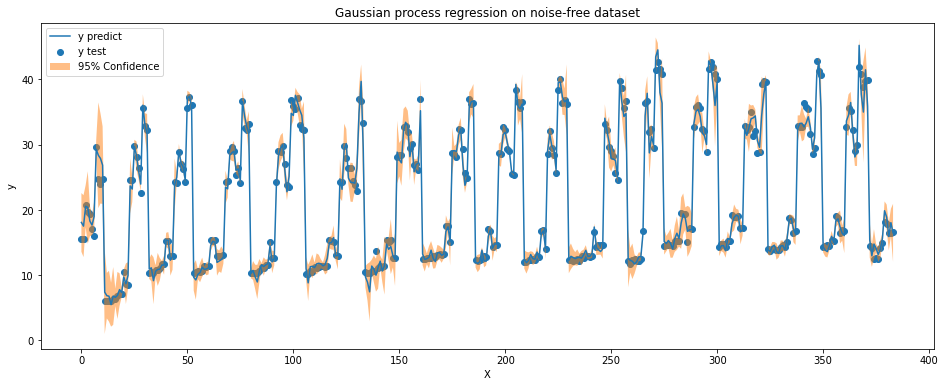

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

mean_pred, std_pred = gaussian_process.predict(X_test, return_std=True)

upper_bound = mean_pred - 1.96 * std_pred
lower_bound = mean_pred + 1.96 * std_pred

plt.figure(figsize=(16,6))

plt.scatter(x = range(len(y_test)),y = y_test,label = 'y test')

plt.plot(mean_pred, label = 'y predict')

plt.fill_between(x = range(len(mean_pred)), y1 = upper_bound, y2 = lower_bound, alpha=0.5, label='95% Confidence')

plt.title("Gaussian process regression on noise-free dataset")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()